# Embedding People of Informatics

Here, embed individuals in different dimensions, as a form of dimensionality reduction. The following models were used to embed individuals:
1. tf-idf 
    - metadata
    - metadata + pdf
2. topic models 
    - topic model derived from metadata
    - topic model derived using documents in DBLP
    
    
## Methodology
1. Derive the models (for topic models, that is already derived in notebook on [topicModelling](topicModels/notebooks/topicModelling.ipynb).
2. Map individuals to the publications that they have published. (a bipartite graph between publications and individuals)
3. FOR each individual, using the publications for each individual, derive the embedding in the ***new*** space.
4. Calculate metrics such as **similarity** between individuals.

---

## Setup

In [1]:
import pandas as pd
from gensim.models import TfidfModel
from gensim.corpora import Dictionary
import gensim.similarities as sim
import os
DATA_DIR = '../../data/data_schoolofinf/'

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

Import tokens for publications

In [3]:
# Tokens from collection
lookup_combined_toks = pd.read_pickle(
    os.path.join(DATA_DIR, 'toks', 'toks.combined.pkl'))

In [4]:
# Filter the list of publications by:
# 1) Number of collaborators for that publication should be at least 2 (otherwise we wont see those authors in the collaboration graph anyway)
# lookup_pub = pd.read_pickle(os.path.join(DATA_DIR, 'lookup_pub.pkl'))
# lookup_pub['num_collab'] = lookup_pub['edges'].apply(lambda x: len(x))
# lookup_pub_atleast2 = lookup_pub.drop(
#     lookup_pub[(lookup_pub.num_collab < 2)].index)

# 2) year of publication
lookup_combined_toks.drop(
    lookup_combined_toks[(lookup_combined_toks.year < 1997)
                         | (lookup_combined_toks.year > 2017)].index,
    inplace=True)

In [5]:
len(lookup_combined_toks)

8028

In [6]:
# Replace empty entries in lookup_combined_toks_rest.toks_pdf2txt with list []
lookup_combined_toks[
    'toks_pdf2txt'] = lookup_combined_toks.toks_pdf2txt.apply(
        lambda x: [] if not len(x) else x)
lookup_combined_toks[
    'toks_metada'] = lookup_combined_toks.toks_metada.apply(
        lambda x: [] if not len(x) else x)

Import individuals to publications mapping:

In [7]:
# We are only interested in individuals in the collab graph:
poinf_ids = pd.read_csv(
    os.path.join(DATA_DIR, 'poinf_collabgraph_1997-2017.txt'),
    sep='\n',
    names=['id'])

In [8]:
df_pubmapping = pd.read_pickle(
    os.path.join(DATA_DIR, 'poinf_to_pub_mapping.pkl'))

In [9]:
# merge the two dataframes, so that those that we are not interested are excluded:
df_pubmapping.set_index('id', inplace=True)
poinf_ids.set_index('id', inplace=True)
df_pubmapping_4_collabgraph = poinf_ids.join(df_pubmapping, how='left')

In [10]:
len(df_pubmapping_4_collabgraph)

194

# Simple embedding using TF-IDF

1. Create TF-IDF for each terms
2. Using the mapping for `poinf-> publications` created, create list of tokens for each indivudal
3. As in information retrieval, find individuals who have are most similar. This is done using `cosine similarity`

## `METADATA` ONLY

### Import metadata corpus:

In [11]:
corpus_metadata = lookup_combined_toks.toks_metada.tolist()

In [12]:
# Create the TFIDF model using the dictionary based on the metadata from 1997-2017
dictionary_metada = Dictionary.load(
    os.path.join(DATA_DIR, 'corpora', 'dictionary.meta'))

In [36]:
tfidf_metada = TfidfModel(dictionary=dictionary_metada, normalize=True)
# tfidf_metada.save(os.path.join(DATA_DIR, 'models', 'tfidf', 'tfidf_metadata'))

In [14]:
corpus_bows = [dictionary_metada.doc2bow(doc) for doc in corpus_metadata]

### Generate tfidf scores for each individual
Using the concatenation of publications (tokens) derived for each individual, we calculate the tfidf score for that individual.

This score is then used to calculate similarities.

In [15]:
_indices = set(lookup_combined_toks.index)
def gen_toks(pub_ids):
    """
    Take in a set of pub_ids and concatenate all the tokens together
    """
    pub_ids = pub_ids.intersection(_indices)
    _df = lookup_combined_toks.loc[list(pub_ids)]
    out = []
    for a in _df.toks_metada.tolist():
        out += a
    return out

In [16]:
df_pubmapping_4_collabgraph['toks'] = df_pubmapping_4_collabgraph[
    'pub_ids'].apply(gen_toks)

In [17]:
df_pubmapping_4_collabgraph.head(3)

,pub_ids,toks
id,,
d089bb44-7d0b-4b3f-b556-27def993d1d1,"{f250eafa-e98c-4aa9-be32-3fa1b7cf5654, d55ecc1...","[exploiting, causality, selective, belief, fil..."
ecd799fb-4f63-44ae-a078-b009099f2c8c,"{ef6d26cd-7202-44fa-aa16-5eed1ce6caed, d0378fc...","[recognising, nested, named, entity, biomedica..."
1997d4be-de27-44bd-ad89-36e6f386225d,"{8caf8c57-534e-438b-903b-e3748a186a12, 8f32852...","[museum, memory, institution, sociological, as..."


In [18]:
df_pubmapping_4_collabgraph[
    'tfidf'] = df_pubmapping_4_collabgraph['toks'].apply(
        lambda x: tfidf_metada[dictionary_metada.doc2bow(x)] if len(x) else None
    )

In [19]:
df_pubmapping_4_collabgraph.info()

<class 'pandas.core.frame.DataFrame'>
Index: 194 entries, d089bb44-7d0b-4b3f-b556-27def993d1d1 to ccd9cd8c-9aee-4ede-a388-f82641ee8d29
Data columns (total 3 columns):
pub_ids    194 non-null object
toks       194 non-null object
tfidf      194 non-null object
dtypes: object(3)
memory usage: 11.1+ KB


### Similarity matrix

In [20]:
index = sim.Similarity(
    output_prefix='20yrs_metadata',
    corpus=df_pubmapping_4_collabgraph.tfidf.tolist(),
    num_features=len(dictionary_metada))

In [21]:
index.save(os.path.join(DATA_DIR, 'models', 'index_20yrs_metadata'))

In [22]:
sim_matrix = []
# USE THE LIST OF INDIVIDUALS ST
for i in range(len(df_pubmapping_4_collabgraph)):
    sim_matrix.append(index[df_pubmapping_4_collabgraph.tfidf.iloc[i]])

### Visualise the similarities

In [23]:
sim_matrix = np.array(sim_matrix)

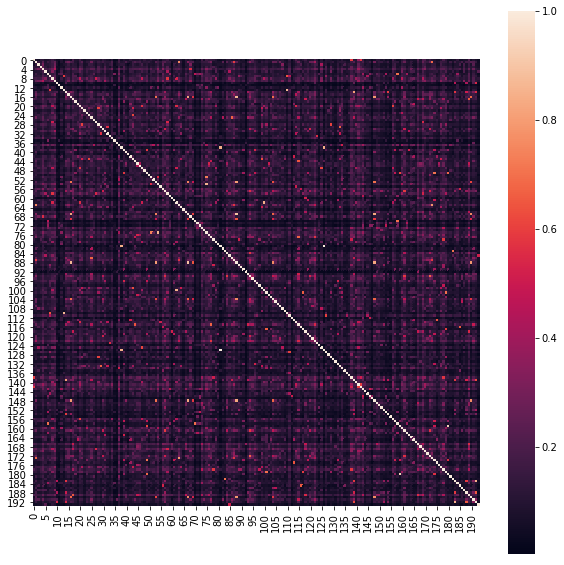

In [24]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
sns.heatmap(sim_matrix, ax=ax, square=True)

### Comparison with ground-truth collab-net:

In [25]:
ground_truth_adj_mat = np.load(os.path.join(DATA_DIR, 'mat', 'infnet20yrs-adj-mat.pkl'))

In [26]:
# We use Scipy.spatial.distance measure for jaccard dissimilarity (distance)
from scipy.spatial.distance import jaccard


def jaccard_dist(x_true, x, theta=None, binary=True):
    """
    Given vectors x_true and x of the same length, calculate the
    jaccard distance between x_true and x.
    Theta is represents the threshold parameter to filter x by. 
    If given, any values in x < theta will be set to 0
    """
    x = np.array(x)
    if binary:
        if theta:
            idx = x < theta
            x[idx] = False
            x[~idx] = True
#             print(x)
            return jaccard(x_true, x)
        else:
            return jaccard(x_true, x)
    else:
        print("not implemented")

In [27]:
x_true = [0, 0, 1]
x = [0., .1, .2]
jaccard_dist(x_true, x, theta=.2) == 0

True

In [32]:
def find_best_threshold(x_trues,
                        xs,
                        start_threshold=0.01,
                        step_size=0.005,
                        num_iter=100):
    """
    An iterative approach to find the best threshold such that x is the most similar to x
    
    We aim to minimise the average jaccard_distance that we calculated. but increasing 
    or decreasing the threshold every iteration, starting from start_threshold.
    
    Stops after num_iter, or when the threshold is greater than 1.
    """
    # Initialise the parameters
    end_conditions = True
    lowest_avg_distance = 1  # maximum possible
    threshold = start_threshold
    best_threshold = 0.
    epoch = 0
    best_epoch = 0

    while (end_conditions):
        distances = np.zeros(x_trues.shape[0])
        i = 0
        for x_true, x in zip(ground_truth_adj_mat, sim_matrix):
            distances[i] = jaccard_dist(
                x_true, x, theta=threshold, binary=True)
            i += 1
        # calculate the mean:
        average_dist = np.mean(distances)
        print(("epoch {}: avg_dist: {:.3f} threshold: {:.3f}".format(epoch, average_dist, threshold)))

        # check if the best epoch is seen
        if (average_dist < lowest_avg_distance):
            best_epoch = epoch
            lowest_avg_distance = average_dist
            best_threshold = threshold

        # Next iteration
        epoch += 1
        threshold += step_size
        end_conditions = (epoch < num_iter) and (threshold < 1.)

    print(('Best epoch: {}: dist {:3f} threshold: {:.3f}'.format(best_epoch,
                                               lowest_avg_distance, best_threshold)))

In [33]:
find_best_threshold(ground_truth_adj_mat, sim_matrix, num_iter=1000)

epoch 0: avg_dist: 0.975 threshold: 0.010
epoch 1: avg_dist: 0.975 threshold: 0.015
epoch 2: avg_dist: 0.975 threshold: 0.020
epoch 3: avg_dist: 0.975 threshold: 0.025
epoch 4: avg_dist: 0.975 threshold: 0.030
epoch 5: avg_dist: 0.974 threshold: 0.035
epoch 6: avg_dist: 0.974 threshold: 0.040
epoch 7: avg_dist: 0.973 threshold: 0.045
epoch 8: avg_dist: 0.972 threshold: 0.050
epoch 9: avg_dist: 0.971 threshold: 0.055
epoch 10: avg_dist: 0.970 threshold: 0.060
epoch 11: avg_dist: 0.968 threshold: 0.065
epoch 12: avg_dist: 0.967 threshold: 0.070
epoch 13: avg_dist: 0.964 threshold: 0.075
epoch 14: avg_dist: 0.962 threshold: 0.080
epoch 15: avg_dist: 0.959 threshold: 0.085
epoch 16: avg_dist: 0.956 threshold: 0.090
epoch 17: avg_dist: 0.952 threshold: 0.095
epoch 18: avg_dist: 0.949 threshold: 0.100
epoch 19: avg_dist: 0.944 threshold: 0.105
epoch 20: avg_dist: 0.939 threshold: 0.110
epoch 21: avg_dist: 0.934 threshold: 0.115
epoch 22: avg_dist: 0.928 threshold: 0.120
epoch 23: avg_dist: 0

Best epoch: 64: dist 0.703742 threshold: 0.330

## `METADATA` + `pdf2txt` too:

### Create corpus

In [34]:
dictionary_all = Dictionary.load(
    os.path.join(DATA_DIR, 'corpora', 'dictionary.all'))

In [35]:
concat_toks = [
    a + b for a, b in zip(lookup_combined_toks.toks_metada.tolist(),
                          lookup_combined_toks.toks_pdf2txt.tolist())
]

In [37]:
tfidf_all = TfidfModel(dictionary=dictionary_all, normalize=True)
tfidf_all.save(os.path.join(DATA_DIR, 'models', 'tfidf', 'tfidf_all'))

In [38]:
corpus_bows = [dictionary_all.doc2bow(doc) for doc in concat_toks]

### Generate tfidf score for each individual

In [39]:
_indices = set(lookup_combined_toks.index)

def gen_toks(pub_ids):
    """
    Take in a set of pub_ids and concatenate all the tokens together
    """
    pub_ids = pub_ids.intersection(_indices)
    _df = lookup_combined_toks.loc[list(pub_ids)]

    # Constraint to 1997-2017
    out = []
    for a,b in zip(_df.toks_metada.tolist(),_df.toks_pdf2txt.tolist()):
        out += a + b
    return out

In [40]:
df_pubmapping_4_collabgraph['toks'] = df_pubmapping_4_collabgraph[
    'pub_ids'].apply(gen_toks)

In [41]:
df_pubmapping_4_collabgraph[
    'tfidf'] = df_pubmapping_4_collabgraph['toks'].apply(
        lambda x: tfidf_all[dictionary_all.doc2bow(x)] if len(x) else None
    )

### Similarity Matrix

In [42]:
index = sim.Similarity(
    output_prefix='20yrs_metadata',
    corpus=df_pubmapping_4_collabgraph.tfidf.tolist(),
    num_features=len(dictionary_all))

In [43]:
index.save(os.path.join(DATA_DIR, 'models', 'index_20yrs_all'))

### Visualisation

In [44]:
sim_matrix = []
for i in range(len(df_pubmapping_4_collabgraph)):
    sim_matrix.append(index[df_pubmapping_4_collabgraph.tfidf.iloc[i]])

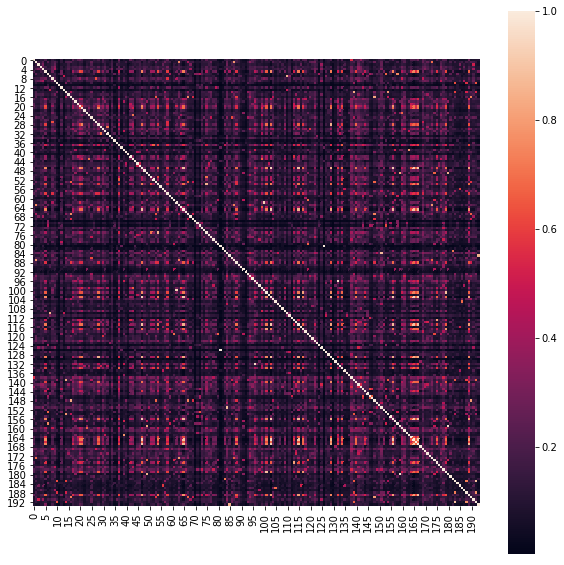

In [46]:
sim_matrix = np.array(sim_matrix)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
sns.heatmap(sim_matrix, ax=ax, square=True)

### Comparison with ground-truth

In [47]:
find_best_threshold(ground_truth_adj_mat, sim_matrix, num_iter=1000)

epoch 0: avg_dist: 0.975 threshold: 0.010
epoch 1: avg_dist: 0.975 threshold: 0.015
epoch 2: avg_dist: 0.975 threshold: 0.020
epoch 3: avg_dist: 0.974 threshold: 0.025
epoch 4: avg_dist: 0.974 threshold: 0.030
epoch 5: avg_dist: 0.973 threshold: 0.035
epoch 6: avg_dist: 0.972 threshold: 0.040
epoch 7: avg_dist: 0.972 threshold: 0.045
epoch 8: avg_dist: 0.971 threshold: 0.050
epoch 9: avg_dist: 0.970 threshold: 0.055
epoch 10: avg_dist: 0.968 threshold: 0.060
epoch 11: avg_dist: 0.967 threshold: 0.065
epoch 12: avg_dist: 0.965 threshold: 0.070
epoch 13: avg_dist: 0.963 threshold: 0.075
epoch 14: avg_dist: 0.960 threshold: 0.080
epoch 15: avg_dist: 0.957 threshold: 0.085
epoch 16: avg_dist: 0.955 threshold: 0.090
epoch 17: avg_dist: 0.951 threshold: 0.095
epoch 18: avg_dist: 0.948 threshold: 0.100
epoch 19: avg_dist: 0.945 threshold: 0.105
epoch 20: avg_dist: 0.940 threshold: 0.110
epoch 21: avg_dist: 0.935 threshold: 0.115
epoch 22: avg_dist: 0.932 threshold: 0.120
epoch 23: avg_dist: 0

best epoch: 69: dist 0.750555 threshold: 0.355

---

# Topic models

In [49]:
from gensim import models

## Model2 : metadata only (1997-2017)

In [50]:
tm_model2 = models.LdaModel.load(os.path.join(DATA_DIR, 'models', 'tm', 'tm_model2'))

In [51]:
dict_meta = Dictionary.load(os.path.join(DATA_DIR,'corpora','dictionary.meta'))

In [52]:
_indices = set(lookup_combined_toks.index)
def gen_toks(pub_ids):
    """
    Take in a set of pub_ids and concatenate all the tokens together
    """
    pub_ids = pub_ids.intersection(_indices)
    _df = lookup_combined_toks.loc[list(pub_ids)]
    out = []
    for a in _df.toks_metada.tolist():
        out += a
    return out

In [53]:
df_pubmapping_4_collabgraph['toks'] = df_pubmapping_4_collabgraph[
    'pub_ids'].apply(gen_toks)

In [54]:
tm_model2.minimum_probability = 0.01 # change the probabilty that we set to 0.01, instead of 0.9

In [55]:
df_pubmapping_4_collabgraph[
    'tm_model2'] = df_pubmapping_4_collabgraph['toks'].apply(
        lambda x: tm_model2.get_document_topics(dict_meta.doc2bow(x)) if len(x) else None
    )

In [56]:
index = sim.Similarity(
    output_prefix='topicmodel2',
    corpus=df_pubmapping_4_collabgraph.tm_model2.tolist(),
    num_features=tm_model2.num_topics
)

In [57]:
index.save(os.path.join(DATA_DIR, 'models', 'index_tm_model2'))

In [58]:
sim_matrix = []
for i in range(len(df_pubmapping_4_collabgraph)):
    # Feed the inferred proportions of the topic model into the similarity matrix
    sim_matrix.append(index[df_pubmapping_4_collabgraph.tm_model2.iloc[i]])

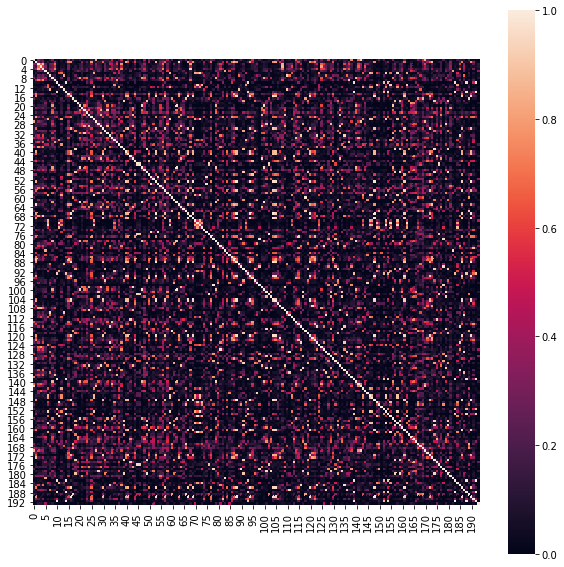

In [60]:
sim_matrix = np.array(sim_matrix)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
sns.heatmap(sim_matrix, ax=ax, square=True)

### Comparison with ground_truth

In [61]:
find_best_threshold(ground_truth_adj_mat, sim_matrix, num_iter=1000)

epoch 0: avg_dist: 0.970 threshold: 0.010
epoch 1: avg_dist: 0.967 threshold: 0.015
epoch 2: avg_dist: 0.965 threshold: 0.020
epoch 3: avg_dist: 0.962 threshold: 0.025
epoch 4: avg_dist: 0.960 threshold: 0.030
epoch 5: avg_dist: 0.957 threshold: 0.035
epoch 6: avg_dist: 0.955 threshold: 0.040
epoch 7: avg_dist: 0.952 threshold: 0.045
epoch 8: avg_dist: 0.950 threshold: 0.050
epoch 9: avg_dist: 0.947 threshold: 0.055
epoch 10: avg_dist: 0.945 threshold: 0.060
epoch 11: avg_dist: 0.943 threshold: 0.065
epoch 12: avg_dist: 0.940 threshold: 0.070
epoch 13: avg_dist: 0.939 threshold: 0.075
epoch 14: avg_dist: 0.936 threshold: 0.080
epoch 15: avg_dist: 0.934 threshold: 0.085
epoch 16: avg_dist: 0.933 threshold: 0.090
epoch 17: avg_dist: 0.930 threshold: 0.095
epoch 18: avg_dist: 0.928 threshold: 0.100
epoch 19: avg_dist: 0.926 threshold: 0.105
epoch 20: avg_dist: 0.925 threshold: 0.110
epoch 21: avg_dist: 0.922 threshold: 0.115
epoch 22: avg_dist: 0.921 threshold: 0.120
epoch 23: avg_dist: 0

Best epoch: 130: dist 0.816328 threshold: 0.660

## DBLP topic model

In [63]:
DATA_DIR = '../../data/data_dblp/'

In [65]:
dict_dblp = Dictionary.load(
    os.path.join(DATA_DIR, 'corpora', 'dictionary.dblp.1997-2017'))

In [66]:
len(dict_dblp)

76471

In [67]:
tm_dblp = models.LdaModel.load(
    os.path.join(DATA_DIR, 'models', 'tm', 'tm_dblp'))
tm_dblp.minimum_probability = 0.01 # change the probabilty that we set to 0.01, instead of 0.9

In [68]:
_indices = set(lookup_combined_toks.index)


def gen_toks(pub_ids):
    """
    Take in a set of pub_ids and concatenate all the tokens together
    """
    pub_ids = pub_ids.intersection(_indices)
    _df = lookup_combined_toks.loc[list(pub_ids)]
    out = []
    for a in _df.toks_metada.tolist():
        out += a
    return out

In [69]:
df_pubmapping_4_collabgraph['toks'] = df_pubmapping_4_collabgraph[
    'pub_ids'].apply(gen_toks)

In [70]:
len(tm_dblp.id2word)

76471

In [71]:
df_pubmapping_4_collabgraph[
    'tm_dblp'] = df_pubmapping_4_collabgraph['toks'].apply(
        lambda x: tm_dblp.get_document_topics(dict_dblp.doc2bow(x)) if len(x) else None
    )

In [79]:
index = sim.Similarity(
    output_prefix='topicmodel_dblp',
    corpus=df_pubmapping_4_collabgraph.tm_dblp.tolist(),
    num_features=tm_dblp.num_topics
)

In [80]:
index.save(os.path.join(DATA_DIR, 'models', 'index_tm_dblp'))

In [74]:
sim_matrix = []
for i in range(len(df_pubmapping_4_collabgraph)):
    sim_matrix.append(index[df_pubmapping_4_collabgraph.tm_dblp.iloc[i]])

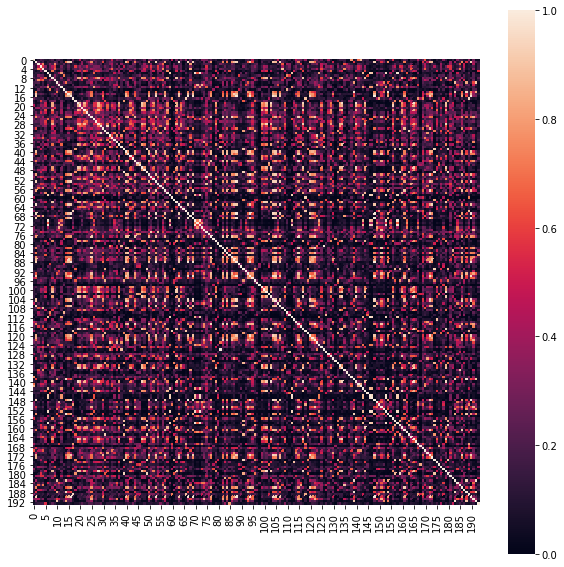

In [77]:
sim_matrix = np.array(sim_matrix)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
sns.heatmap(sim_matrix, ax=ax, square=True)

### Comparison with ground truth

In [78]:
find_best_threshold(ground_truth_adj_mat, sim_matrix, num_iter=1000)

epoch 0: avg_dist: 0.973 threshold: 0.010
epoch 1: avg_dist: 0.973 threshold: 0.015
epoch 2: avg_dist: 0.972 threshold: 0.020
epoch 3: avg_dist: 0.971 threshold: 0.025
epoch 4: avg_dist: 0.970 threshold: 0.030
epoch 5: avg_dist: 0.969 threshold: 0.035
epoch 6: avg_dist: 0.968 threshold: 0.040
epoch 7: avg_dist: 0.967 threshold: 0.045
epoch 8: avg_dist: 0.966 threshold: 0.050
epoch 9: avg_dist: 0.965 threshold: 0.055
epoch 10: avg_dist: 0.963 threshold: 0.060
epoch 11: avg_dist: 0.962 threshold: 0.065
epoch 12: avg_dist: 0.961 threshold: 0.070
epoch 13: avg_dist: 0.960 threshold: 0.075
epoch 14: avg_dist: 0.959 threshold: 0.080
epoch 15: avg_dist: 0.957 threshold: 0.085
epoch 16: avg_dist: 0.956 threshold: 0.090
epoch 17: avg_dist: 0.954 threshold: 0.095
epoch 18: avg_dist: 0.953 threshold: 0.100
epoch 19: avg_dist: 0.951 threshold: 0.105
epoch 20: avg_dist: 0.950 threshold: 0.110
epoch 21: avg_dist: 0.949 threshold: 0.115
epoch 22: avg_dist: 0.947 threshold: 0.120
epoch 23: avg_dist: 0

Best epoch: 137: dist 0.829202 threshold: 0.695

# Summary of results compared to ground truth of informatics collab network

|Model |Average Jaccard Distance* | Threshold required | 
|---|---|---|
|tfidf (metadata) | 0.703 | 0.330|
|tfidf (metadata+pdf) | 0.751 |0.355 |
| Topic model (metadata) |0.816 |0.660 |
| Topic model (dblp) | 0.829 | 0.695 |

- [ ] Filter the topic model to reduce noise?
- [ ] Does this necessarily means it is not good?

## Visualise networks induce from embeddings: